In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


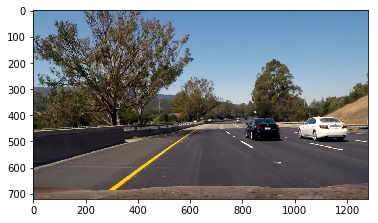

In [2]:
#reading in an image
image = mpimg.imread('test_images/test6.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

The goals / steps of this project are the following:
1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


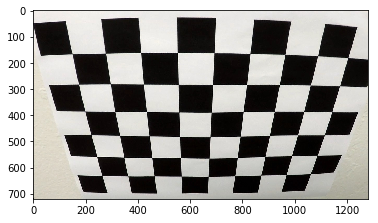

In [3]:
# 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

# reading in and printing out an image for calibration to examine
image = mpimg.imread('camera_cal/calibration2.jpg')
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)

## Camera Calibration

In [4]:
import glob

# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 3d points in image plane.

# make a list of calibration image
images = glob.glob('camera_cal/calibration*.jpg')

# step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # if found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


## Undistortion

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


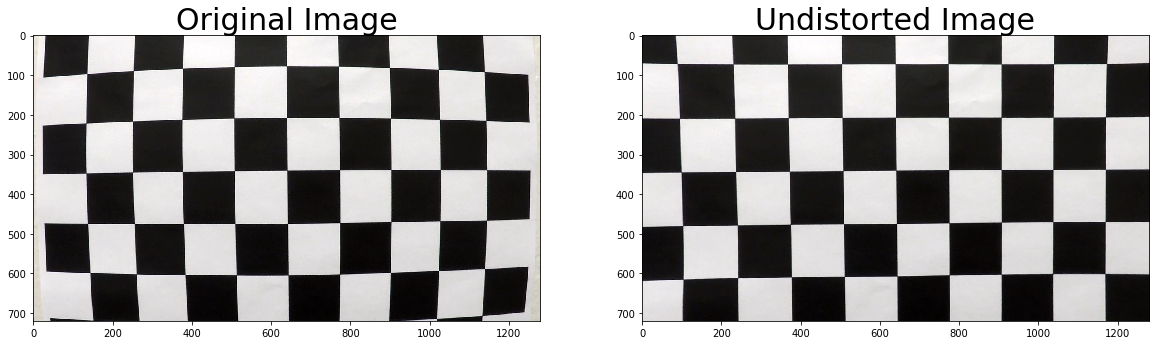

In [5]:
#reading in an image
# img = cv2.imread('test_images/test1.jpg')
img = mpimg.imread('camera_cal/calibration1.jpg')
#printing out some stats of the test image
print('This image is:', type(image), 'with dimesions:', image.shape)

img_size = (img.shape[1], img.shape[0])

# do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img,mtx,dist,None,mtx)

# visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


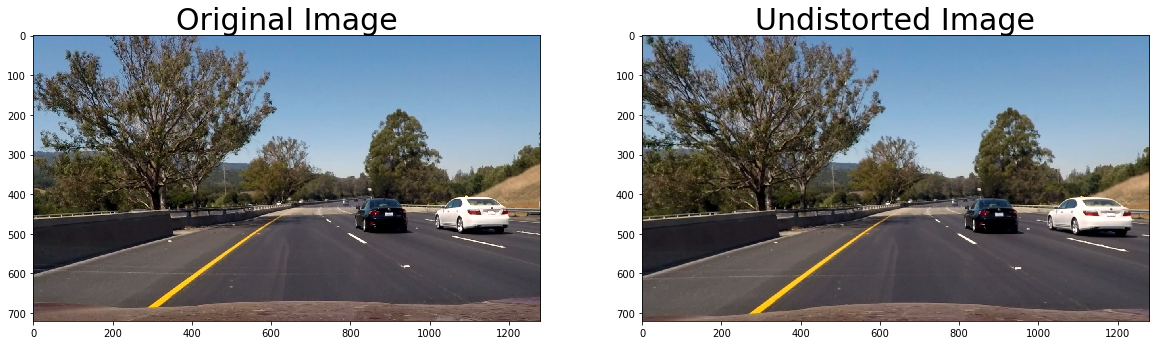

In [6]:
# 2. Apply a distortion correction to raw images.

import pickle
%matplotlib inline

#reading in an image
# img = cv2.imread('test_images/test1.jpg')
img = mpimg.imread('test_images/test6.jpg')
#printing out some stats of the test image
print('This image is:', type(image), 'with dimesions:', image.shape)

img_size = (img.shape[1], img.shape[0])

# do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img,mtx,dist,None,mtx)

# visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Gradient

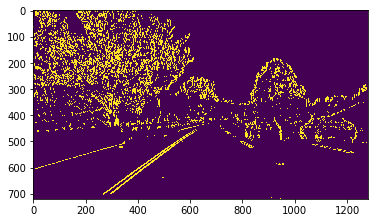

In [7]:
# 3. Use color transforms, gradients, etc., to create a thresholded binary image.

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output    

bin_absx_dst = abs_sobel_thresh(dst, 'x', 15, (30, 100))
plt.imshow(bin_absx_dst)


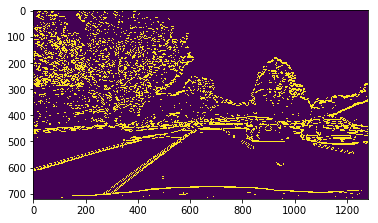

In [8]:
bin_absy_dst = abs_sobel_thresh(dst, 'y', 15, (30, 100))
plt.imshow(bin_absy_dst)

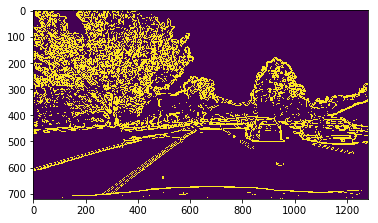

In [9]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

bin_mag_dst = mag_thresh(dst, 15, (30, 100))
plt.imshow(bin_mag_dst)

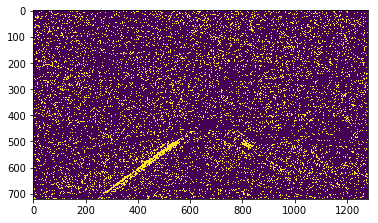

In [10]:
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

bin_dir_dst = dir_thresh(dst, 15, (0.9, 1.1))
plt.imshow(bin_dir_dst)

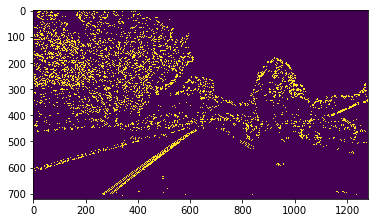

In [11]:
# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(dst, orient='x', sobel_kernel=ksize, thresh=(30, 100))
grady = abs_sobel_thresh(dst, orient='y', sobel_kernel=ksize, thresh=(30, 100))
mag_binary = mag_thresh(dst, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_thresh(dst, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.imshow(combined)

## Color Space

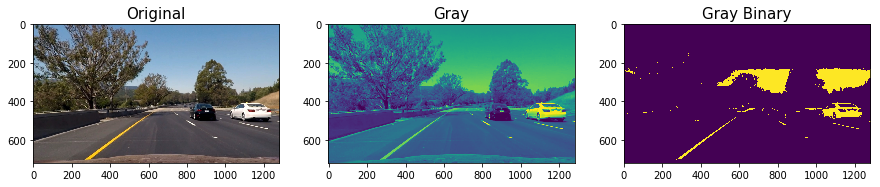

In [12]:
# gray = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)
thresh = (180, 255)
# image = mpimg.imread('test_images/test6.jpg')
image = dst
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7.5))
ax1.imshow(image)
ax1.set_title('Original', fontsize=15)
ax2.imshow(gray)
ax2.set_title('Gray', fontsize=15)
ax3.imshow(binary)
ax3.set_title('Gray Binary', fontsize=15)

# plt.imshow(gray)
# plt.imshow(binary)

(720, 1280, 3)


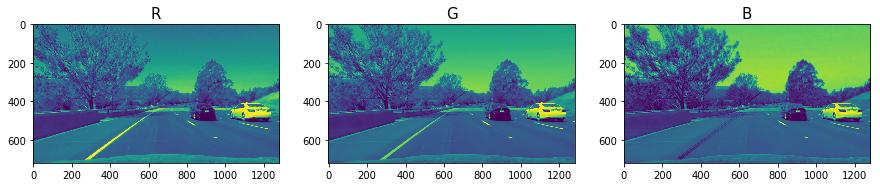

In [13]:
rgb = dst
print(rgb.shape)
R = rgb[:,:,0]
G = rgb[:,:,1]
B = rgb[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7.5))
ax1.imshow(R)
ax1.set_title('R', fontsize=15)
ax2.imshow(G)
ax2.set_title('G', fontsize=15)
ax3.imshow(B)
ax3.set_title('B', fontsize=15)

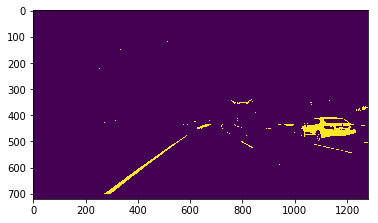

In [14]:
thresh = (200, 255)
binary = np.zeros_like(R)
binary[(R > thresh[0]) & (R <= thresh[1])] = 1
plt.imshow(binary)

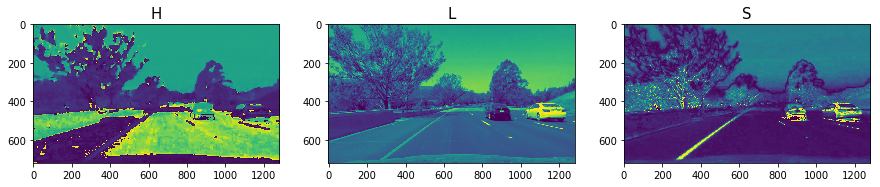

In [15]:
hls = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7.5))
ax1.imshow(H)
ax1.set_title('H', fontsize=15)
ax2.imshow(L)
ax2.set_title('L', fontsize=15)
ax3.imshow(S)
ax3.set_title('S', fontsize=15)


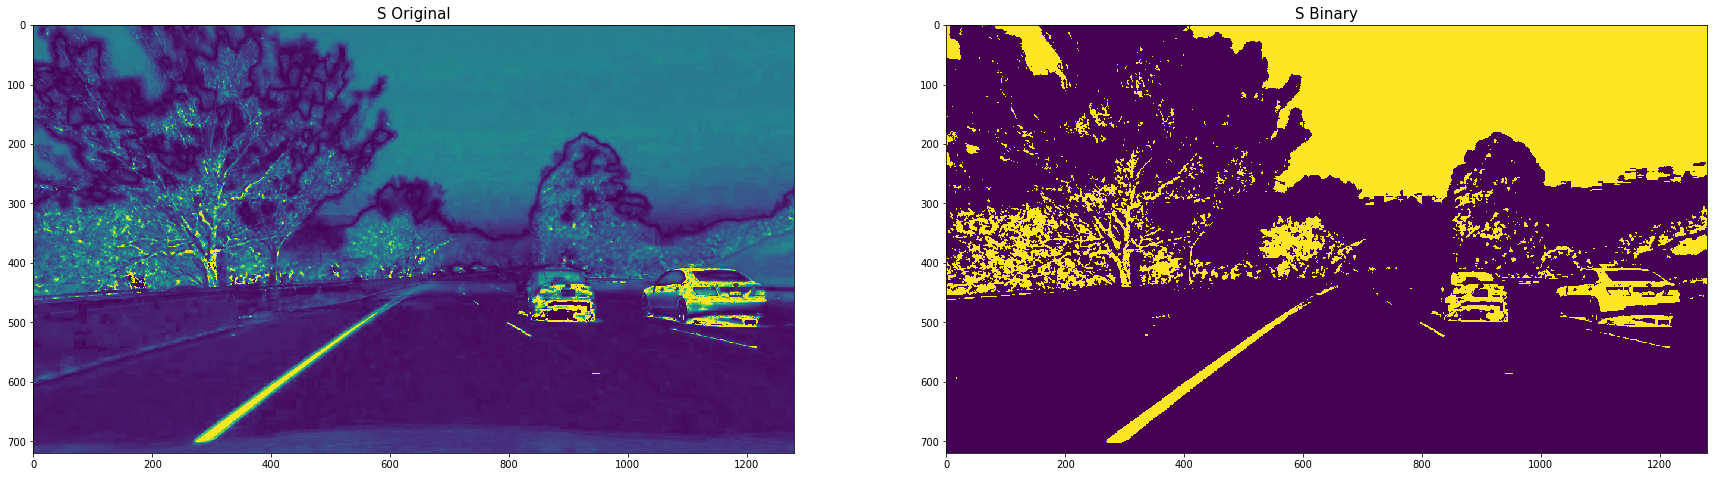

In [16]:
thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1

f, (ax1, ax2) = plt.subplots(1,2,figsize=(30,15))
ax1.imshow(S)
ax1.set_title('S Original', fontsize=15)
ax2.imshow(binary)
ax2.set_title('S Binary', fontsize=15)

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


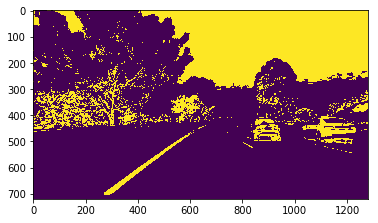

In [17]:
def hls_select(img, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

img = mpimg.imread('test_images/test6.jpg')
#printing out some stats of the test image
print('This image is:', type(image), 'with dimesions:', image.shape)

# img_size = (img.shape[1], img.shape[0])

# do camera calibration given object points and image points
# ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img,mtx,dist,None,mtx)

# plt.imshow(dst)

s_bin_dst = hls_select(dst, (90,255))
plt.imshow(s_bin_dst)

## Gradient and Color Combined

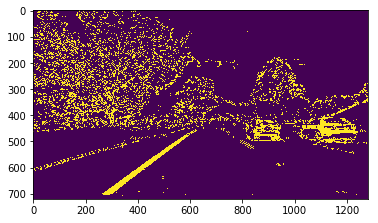

In [18]:
## Test suites

img = mpimg.imread('test_images/test6.jpg')
dst = cv2.undistort(img,mtx,dist,None,mtx)

# Gradient
ksize = 15 # Choose a larger odd number to smooth gradient measurements
gradx = abs_sobel_thresh(dst, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(dst, orient='y', sobel_kernel=ksize, thresh=(30, 100))
mag_binary = mag_thresh(dst, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_thresh(dst, sobel_kernel=ksize, thresh=(0.7, 1.3))

# Color (S)
s_binary = hls_select(dst, (120,255))

combined = np.zeros_like(s_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
# combined[(gradx == 1) | (s_binary == 1)] = 1

plt.imshow(combined)

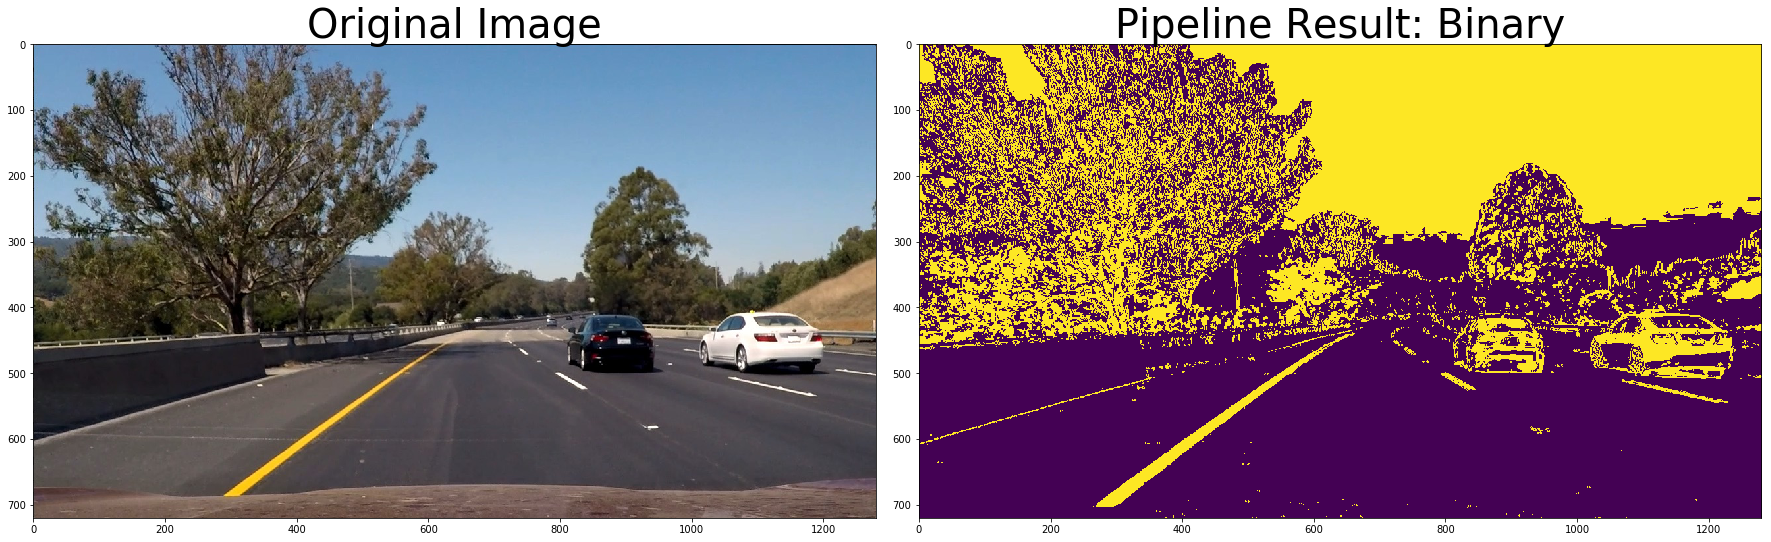

In [19]:
## Pipeline
image = mpimg.imread('test_images/test6.jpg')
dst = cv2.undistort(image,mtx,dist,None,mtx)

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(90, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return color_binary, combined_binary
    
color, binary = pipeline(dst)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary)
ax2.set_title('Pipeline Result: Binary', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

##  Perspective Transform

[[  700.           440.        ]
 [ 1137.77783203   720.        ]
 [  256.           720.        ]
 [  640.           440.        ]]
[[ 960.    0.]
 [ 960.  720.]
 [ 320.  720.]
 [ 320.    0.]]


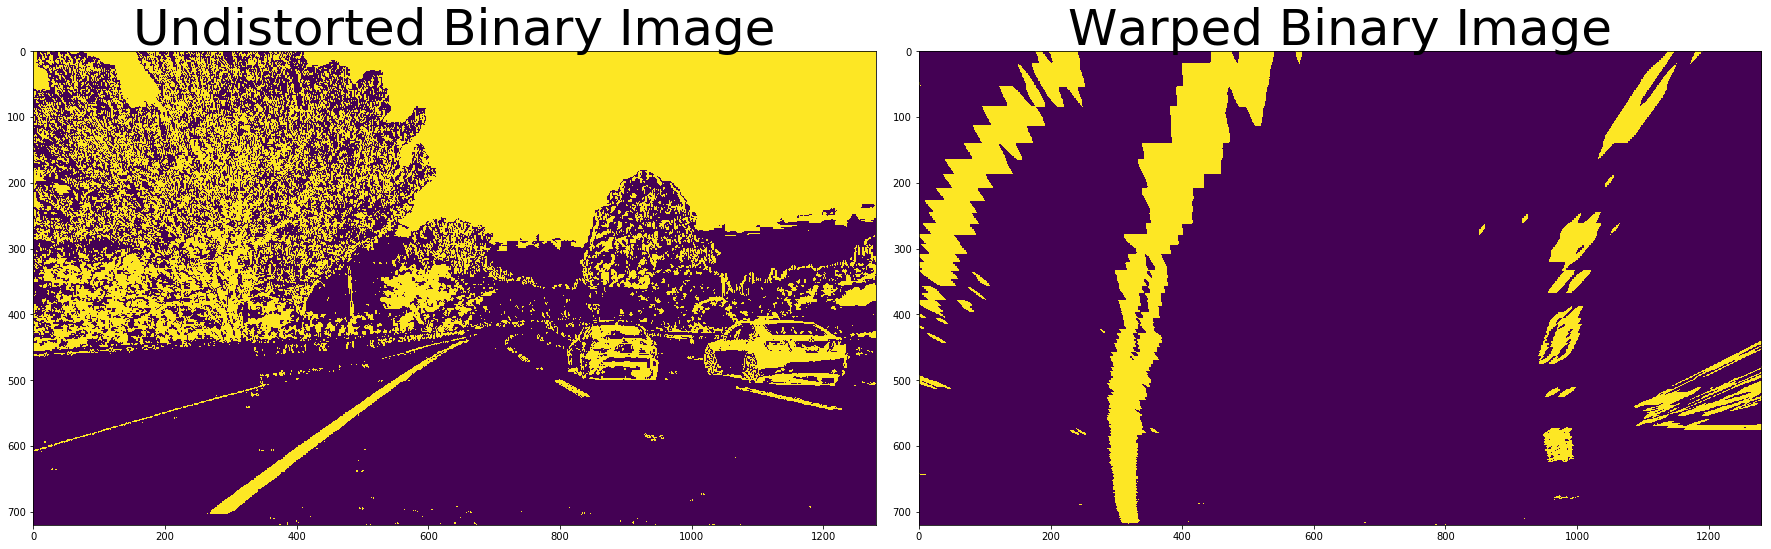

In [20]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients

def draw_line(img, src, color=[255,0,0]):
    x1, y1 = src[0]
    x2, y2 = src[1]
    cv2.line(img, (x1, y1), (x2, y2), color, 5)
    x3, y3 = src[2]
    x4, y4 = src[3]
    cv2.line(img, (x3, y3), (x4, y4), color, 5)
    return img

def perspective_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
#     draw_line(warped, dst)
    return warped, M

# image = mpimg.imread('test_images/test6.jpg')
# image = np.zeros_like(binary)
# # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# # img_size = (gray.shape[1], gray.shape[0])
img_size = (binary.shape[1], binary.shape[0])
center_x = img_size[0]/2
center_y = img_size[1]/2

# pt_src = np.float32(
#     [[center_x+40,center_y+80],
#      [img_size[0]*(4/5),img_size[1]],
#      [img_size[0]*(1/4),img_size[1]],
#      [center_x-20,center_y+80]])

pt_src = np.float32(
    [[center_x+60,center_y+80],
     [img_size[0]*(8/9),img_size[1]],
     [img_size[0]*(1/5),img_size[1]],
     [center_x,center_y+80]])

pt_dst = np.float32([
    [img_size[0]*(3/4),0], 
    [img_size[0]*(3/4),img_size[1]],   
    [img_size[0]*(1/4),img_size[1]], 
    [img_size[0]*(1/4),0]])

print(pt_src)
print(pt_dst)

# # dst = cv2.undistort(image,mtx,dist,None,mtx)
# # top_down, perspective_M = perspective_transform(dst, pt_src, pt_dst)
# # top_down, perspective_M = perspective_transform(dst, pt_src, pt_dst)
binary_warped, perspective_M = perspective_transform(binary, pt_src, pt_dst)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
# draw_line(binary, pt_src)
ax1.imshow(binary)
ax1.set_title('Undistorted Binary Image', fontsize=50)
ax2.imshow(binary_warped)
ax2.set_title('Warped Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 27
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 70
# Set minimum number of pixels found to recenter window
minpix = 150
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

/Users/hiro99ishikawa/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(720, 0)

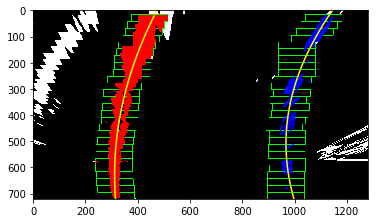

In [22]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

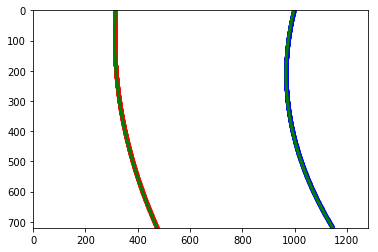

In [23]:
leftx = left_fitx[::-1]  # Reverse to match top-to-bottom in y
rightx = right_fitx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [24]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
# left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
# right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
# print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

405.300432641 m 242.513133746 m


## Video Test

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [26]:
def process_image(image):
    dst = cv2.undistort(image,mtx,dist,None,mtx)
    color, binary = pipeline(dst)
    return binary

In [27]:
white_output = 'combined.mp4'
# clip1 = VideoFileClip("detect.mp4")
clip1 = VideoFileClip("project_video.mp4").subclip(25,30)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video combined.mp4
[MoviePy] Writing video combined.mp4


 99%|█████████▉| 125/126 [00:25<00:00,  4.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: combined.mp4 

CPU times: user 22.6 s, sys: 3.72 s, total: 26.3 s
Wall time: 26.1 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

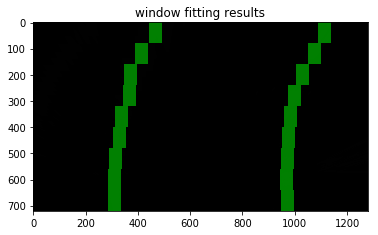

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
# warped = mpimg.imread('warped_example.jpg')
warped = np.copy(binary_warped)
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 70 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()
